# Implementation


Dans cette section, nous allons récupérer le contenu de la base de données afin de crééer à nouveau le graphe
précédement généré.

Ce notebook est construit de la manière suivante :
- Récupération des données et création du graphe
- Anaylses statistiques
- Résolution du problème VRP avec le graphe généré

## Récupération des données contenues dans la base de données.



In [145]:
from pprint import pp
import dwave_networkx as dnx
import networkx as nx
import numpy as np
from pymongo import MongoClient
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
import math


def get_db_connection() :
    client = MongoClient('localhost', 27017)
    db = client['projet']
    return db

addresses = get_db_connection()["addresses"].find({}).sort([("id",1)])
segments = get_db_connection()["segments"].find({}).sort([("id",1)])
segments = list(segments)
addresses = list(addresses)
segments_dict = {}
nb_ad = len(list(addresses))
mat = np.zeros((nb_ad,nb_ad), int)
G = nx.DiGraph()

for segment in segments:
    time = segment["distance"]/segment["speed_by_hour"][0]*60
    segments_dict[segment["id"]] = segment
    mat[segment["direction"]["departure"]["id"]][segment["direction"]["arrival"]["id"]] = time
    G.add_edge(segment["direction"]["departure"]["id"],segment["direction"]["arrival"]["id"])


## Étude statistique

Afin de résoudre le probleme de manière optimisée, il est nécéssaire de savoir quelles valeurs d'entrée
lui fournir. Dans notre étude, nous avons décidé d'étudier le nombre minimum de camions nécéssaires
afin de réaliser une tournée en fonction du nombre d'addresses à livrer.

Ces données sont calculées sur un grand nombre de graphes générés aléatoirement à l'aide de la méthode de
génération étudiée dans les précédents notebooks.

Cette étude statistique a été élaborée en attribuant le temps maximum de chaque camion à 180min
et la capacité de chaque vehicule à 200.

### fonction get_nb_vehicles
Cette fonction permet de déterminer le nombre minimum de vehicules nécéssaires afin qu'une tournée de
livraison soit réalisable en prenant en entrée le nombre de marchandises qu'un vehicule peut transporter.

In [146]:
def get_nb_vehicles(min_vehicles,load):
    data = resolve_problem(min_vehicles,load)
    while data is None:
        print('No solution found for ' + str(min_vehicles) + ' vehicles')
        min_vehicles += 1
        data = resolve_problem(min_vehicles,load)
    print('Solution found for ' + str(min_vehicles) + ' vehicles')
    data['min-vehicles'] = min_vehicles
    return data




### fonction get_function_equation
Cette fonction permet, à partir de l'échantillon de données, de retourner l'équation de la droite
passant par une nuage de points. De cette manière, nous obtenons une fonction permettant de prédire le
nombre minimum optimal de vehicules pour une livraison à n adresses.

In [148]:
def get_function_equation(x, y):
    # initialisation des sommes
    x_sum = 0.
    x2_sum = 0.
    y_sum = 0.
    xy_sum = 0.
    # calcul des sommes
    for xi, yi in zip(x, y):
        x_sum += xi
        x2_sum += xi**2
        y_sum += yi
        xy_sum += xi * yi
    # nombre de points
    npoints = len(x)
    # calcul des paramétras
    a = (npoints * xy_sum - x_sum * y_sum) / (npoints * x2_sum - x_sum**2)
    b = (x2_sum * y_sum - x_sum * xy_sum) / (npoints * x2_sum - x_sum**2)
    # renvoie des parametres
    return a, b



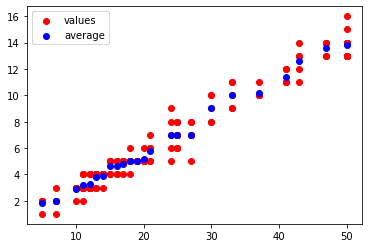

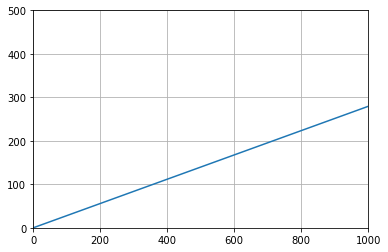

a : 0.27917663913524676
b : 0.08116161006960096
Estimated vehicles for 200 addresses : 56


In [149]:

def graphics():
    db = get_db_connection()
    collection = db['results']
    db_results = collection.aggregate([{
        "$group" :
            {
                "_id" : "$nb_addresses",
                "nb_vehicles" : {
                    "$avg" : "$nb_vehicles"
                }
            },
    }
    ])
    db_results = list(db_results)
    tb = []
    for elem in db_results :
        if elem["_id"] <= 50:
            tb.append(elem)
    result = {}
    nb_vehicles = []
    nb_addresses = []
    for elem in tb:
        r = collection.find({
            "nb_addresses" : elem["_id"]
        })
        list_nb = []
        r = list(r)
        for nb in r:
            list_nb.append(nb["nb_vehicles"])
            nb_vehicles.append(nb["nb_vehicles"])
            nb_addresses.append(nb["nb_addresses"])
        result[elem["_id"]] = list_nb

    nb_vehicles_avg = []
    nb_addresses_avg = []
    for elem in tb:
        nb_addresses_avg.append(elem['_id'])
        nb_vehicles_avg.append(elem['nb_vehicles'])

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.scatter(nb_addresses,nb_vehicles, c='r', label='values')
    ax1.scatter(nb_addresses_avg,nb_vehicles_avg, c='b', label='average')
    plt.legend(loc='upper left');
    plt.show()

    a,b = get_function_equation(nb_addresses,nb_vehicles)
    x = np.arange(0,1000,0.1)

    def f(x):
        return a * x + b
    y = f(x)

    plt.grid()
    plt.xlim(0,1000)
    plt.ylim(0,500)
    plt.plot(x,y)
    plt.show()

    print('a : ' + str(a))
    print('b : ' + str(b))
    nb_vehicles = 200
    print("Estimated vehicles for "+ str(nb_vehicles) + " addresses : " + str(math.ceil(f(nb_vehicles))))
    return a,b

def get_nb_vehicles_from_nb_addresses(nb_addresses):
    return a * nb_addresses + b

a,b = graphics()


Nous pouvons voir que nous obtenons plusieurs courbes :

- La premiere courbe contient deux nuages de points : Les nuages de points des différentes études
statistiques réalisées (en rouge) et la moyenne de ces valeurs (en bleu)
- La deuxieme courbe est la droite passant le plus près possible de chaque point du nuage de points rouges.
Cette droite est un ajustement affine du nuage de points et est décrite par le coefficient directeur moyen
reliant tous les points du nuage de points. L'éaquation de cette droite est donc une fonction affine
dont les valeurs ont été calculées, et correspondent à a et b : $f(x)$ = ax+b.

A l'aide de cette étude, nous pouvons maintenant obtenir le nombre de vehicules nécéssaires pour une tournée
de n adresses.

## Résolution du problème

Maintenant que nous avons récupéré notre graphe et étudié à l'aide de statistiques son comportement,
nous allons l'utiliser pour résoudre le probleme.
Pour cela, nous allons utiliser la librairie "or-tools" founie par google en utilisant la meta-heuristique
de recherche tabou.

### Définition des fonctions utilisées lors de la résolution

In [150]:
def create_data_model(nb_vehicle, load, mat,addresses):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = mat
    data['demands'] = []
    for address in addresses:
        data['demands'].append(address["merchandises_by_type"]['1'])
    data['total_load'] = sum(data['demands'])
    data['num_vehicles'] = nb_vehicle
    data["vehicle_capacities"] = []
    for i in range(0,data['num_vehicles']):
        data["vehicle_capacities"].append(load)
    data['depot'] = 0

    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    unused_vehicles = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        if route_load == 0:
            unused_vehicles += 1
        else:
            plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                      route_load)
            plan_output += 'Time of the route: {}min\n'.format(route_distance)
            plan_output += 'Products delivered: {}\n'.format(route_load)
            print(plan_output)
            total_distance += route_distance
            total_load += route_load
    print('Total time of all routes: {}m'.format(total_distance))
    print('Total Products delivered: {}'.format(total_load))
    print('Unused vehicles ' + str(unused_vehicles))


def resolve_problem(nb_vehicle,load,max_travel_time):
    data = create_data_model(nb_vehicle,load,mat,addresses)

    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    routing = pywrapcp.RoutingModel(manager)


    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    dimension_name = 'Time'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        max_travel_time,  # vehicle maximum travel Time
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(150)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.seconds = 3
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        print_solution(data, manager, routing, solution)
        return data
    print('no solution')
    return None

## Déclaration des données et resolution du probleme

Nous allons maintenant utiliser l'analyse statistiques et les fonctions précédemments définies afin
de résoudre le problème.
Pour ce faire, nous allons premierement récupérer le nombre de vehicules nécéssaires
à la tournée à l'aide de la fonction "get_nb_vehicles_from_nb_addresses" précedement créée.
Enfin, nous allons appeler l'algorithme de résolution afin d'afficher les différentes routes choisies pour
chaque vehicule, tout en minimisant le temps.



In [151]:
nb_addresses = len(addresses)

""" gets the number of vehicle from the function generated from the statistics and adds a margin of error """
nb_vehicles = math.ceil(get_nb_vehicles_from_nb_addresses(nb_addresses)) + 2
print("number of vehicles for " + str(nb_addresses) + " addresses -> " + str(nb_vehicles) + " vehicles \n")

"""sets the capcity of each vehicle to 200"""
capacity = 200

"""sets the max travel time for each vehicle"""
max_travel_time = 180
""" resolves the problem and print the solution for the generated graph """
result = resolve_problem(nb_vehicles,capacity,max_travel_time)

# display_graph(mat)



number of vehicles for 100 addresses -> 30 vehicles 

Route for vehicle 0:
 0 Load(0) ->  8 Load(10) ->  92 Load(105) ->  41 Load(137) ->  0 Load(137)
Time of the route: 40min
Products delivered: 137

Route for vehicle 1:
 0 Load(0) ->  18 Load(100) ->  78 Load(137) ->  96 Load(178) ->  0 Load(178)
Time of the route: 70min
Products delivered: 178

Route for vehicle 2:
 0 Load(0) ->  12 Load(94) ->  82 Load(148) ->  55 Load(187) ->  0 Load(187)
Time of the route: 36min
Products delivered: 187

Route for vehicle 3:
 0 Load(0) ->  71 Load(27) ->  7 Load(99) ->  63 Load(124) ->  38 Load(195) ->  0 Load(195)
Time of the route: 39min
Products delivered: 195

Route for vehicle 4:
 0 Load(0) ->  35 Load(23) ->  58 Load(118) ->  61 Load(192) ->  0 Load(192)
Time of the route: 30min
Products delivered: 192

Route for vehicle 5:
 0 Load(0) ->  97 Load(75) ->  56 Load(174) ->  0 Load(174)
Time of the route: 49min
Products delivered: 174

Route for vehicle 6:
 0 Load(0) ->  90 Load(91) ->  47 Load(

# Démonstration

Afin de valider notre modele, nous allons résoudre le probleme pour un nombre petit d'adresses
et vérifier les résultats.

Le graphe de démonstration ne s'affiche que pour un graphe à 5 sommets.




In [152]:

if nb_addresses == 5:
    nx.draw(G,with_labels=True)
    print("time for each segment :")
    for segment in segments:
        time = segment["distance"]/segment["speed_by_hour"][0]*60
        departure_id = str(segment["direction"]["departure"]["id"])
        arrival_id =str(segment["direction"]["arrival"]["id"])

        print('segment from ' + str(departure_id) +
              ' to ' +  str(arrival_id) +
              ' -> time : ' + str(time))

    for address in addresses :

        print("load of address " + str(address['id']) + " -> " +
        str(address["merchandises_by_type"]['1']))
